## TODO ##
- dodać lime
- wydzielić sensowne fragmenty kodu do plików pythonowych
- odpalić kod na innych datasetach
- odpalić więcej random-searchów
- dodać readme
- odpalić na obciętym datasecie
- wrzucić rezultaty do README.md
- https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

---

- na całym zbiorze danych
- random forest + xgboost
- CNN
- grid search z i be normalizacji

In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from collections import Counter

from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import  metrics

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


## Load datasets ##

In [138]:
from types import SimpleNamespace 
from typing import Tuple


class Dataset:
    def __init__(self, path):
        self.path = path

        dataset = dict(np.load(self.path, allow_pickle=True))
        
        self.X = dataset.pop('X')
        self.y = dataset.pop('y')
        self.meta = dataset.pop('meta')[()]
        
        assert len(dataset) == 0
        
        self.y_binary = np.where(self.y == None, 0, 1)
    
    def normalize(self, mean=None, std=None):
        # TODO: czy powinniśmy normalizować per współrzędna czy globalnie?
        if mean is None:
            mean = np.mean(self.X, axis=0)
            
        if std is None:
            std = np.std(self.X, axis=0, ddof=1)
            
        # NOTE: inplace operators to prevent memory allocations
        self.X -= mean
        self.X /= std
        
        return mean, std
    
    def sample(self, n, *, balanced=False, with_idx=False, random_state=None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Choice `n` random samples from dataset.
        
        @param n: number of random samples to choose,
        @param balanced: if True number of samples for each class will be aprox. equal,
        @param with_idx: return data indexes of sampled records,
        @param random_state: random state used to generate samples indices,
        """
        assert len(self.y_binary.shape) == 1
        
        if balanced:
            counts = Counter(self.y_binary)
            class_count = len(counts)
            
            # NOTE: https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array/35216364
            probs = np.array([1.0 / (class_count * counts[x]) for x in self.y_binary])
        else:
            probs = None
            
        idx = np.random.RandomState(random_state).choice(self.y.size, size=n, p=probs)
        
        if with_idx:
            return idx, self.X[idx], self.y_binary[idx]
        
        return self.X[idx], self.y_binary[idx]
    
    def frame_to_time(self, frame: int) -> float:
        """Convert frame id to time in sec."""
        return librosa.core.frames_to_time(
            frame,
            sr=self.meta['sampling_rate'],
            hop_length=self.meta['hop_length'],
            n_fft=self.meta['n_fft']
        )

In [287]:
train_data = test_data = None
train_data = Dataset('ch1-2018-11-20_10-29-02_0000012.wav.trimed.npz')
print(train_data.path, Counter(train_data.y_binary))

mean, std = train_data.normalize()
print("mean: %f; std: %f" % (np.mean(train_data.X), np.std(train_data.X, ddof=1)))

#################################################################
print()
test_data = Dataset('ch1-2018-11-20_10-26-36_0000010.wav.trimed.npz')
print(test_data.path, Counter(test_data.y_binary))

test_data.normalize(mean, std)
print("mean: %f; std: %f" % (np.mean(test_data.X), np.std(test_data.X, ddof=1)))

ch1-2018-11-20_10-29-02_0000012.wav.trimed.npz Counter({0: 196372, 1: 38013})
mean: 0.000000; std: 1.000209

ch1-2018-11-20_10-26-36_0000010.wav.trimed.npz Counter({0: 213835, 1: 20550})
mean: -0.015875; std: 0.959750


In [141]:
test_data.sample(10, with_idx=True, random_state=1)[0]

array([128037, 229611, 208780,   5192, 229119,  50057, 109259,  73349,
       117583,  21440])

# SVM classification #

### Correlation matrix ###

In [142]:
corr = np.corrcoef(train_data.X.T)
print(corr.shape)

plt.figure(figsize=(14,12))
sns.heatmap(corr)

MemoryError: Unable to allocate array with shape (257, 234385) and data type float64

## Sample data for training ##

In [148]:
N_samples = 5000

X, y = train_data.sample(N_samples, balanced=True, random_state=43)

print(X.shape)
print(Counter(y))

(5000, 257)
Counter({0: 2542, 1: 2458})


## Test baseline model ##

In [106]:
def evaluate_model(model, dataset, n=10000, balanced=False):
    idx, X, y_true = dataset.sample(n, balanced=balanced, with_idx=True)
    
    y_pred = model.predict(X)

    print(confusion_matrix(y_true, y_pred))

    print('accuracy:', accuracy_score(y_true, y_pred))
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print('precision:', precision)
    print('recall:', recall)
    print('fscore:', fscore)
    c = Counter(y_true)
    print('support:', c)
    
    return idx, y_pred, y_true

In [146]:
# model = SVC(kernel='rbf', gamma='auto') # 0.9021
# model = SVC(kernel='poly', degree=3, gamma='auto') # 0.93335
# model = SVC(kernel='poly', degree=2, gamma='auto') # 0.9414
# model = SVC(kernel='linear', degree=1, gamma='auto') # 0.9402
# model = SVC(kernel='sigmoid', gamma='auto')
model = SVC(kernel='poly', degree=1, gamma='auto') # 0.9424

c = Counter(y)
print(c)
print('Baselines:')
print('weighted random accuracy:', sum(i*i for i in c.values()) / sum(c.values())**2)
print('max random accuracy:', max(c.values()) / sum(c.values()))
print()

model.fit(X, y)
print('Done')

# Evaluation
print('Trainset:')
evaluate_model(model, train_data)

print()
print('TestSet:')
print('unbalanced:')
evaluate_model(model, test_data)
print('balanced:')
evaluate_model(model, test_data, balanced=True)

Counter({0: 2535, 1: 2465})
Baselines:
weighted random accuracy: 0.500098
max random accuracy: 0.507

Done
Trainset:
[[8262  160]
 [ 558 1020]]
accuracy: 0.9282
precision: 0.900570736769284
recall: 0.813694984979589
fscore: 0.849011962037822
support: Counter({0: 8422, 1: 1578})

TestSet:
unbalanced:
[[9006  131]
 [ 374  489]]
accuracy: 0.9495
precision: 0.8744188045945388
recall: 0.776145365937916
fscore: 0.8161009013932667
support: Counter({0: 9137, 1: 863})
balanced:
[[5040   79]
 [2151 2730]]
accuracy: 0.777
precision: 0.8363761038072244
recall: 0.7719394573862419
fscore: 0.7644297350943706
support: Counter({0: 5119, 1: 4881})


(array([ 49389, 118573,  12937, ...,  34658, 159520, 126485]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 0, 1, 0]))

# Hyperparameters optimization (with RandomizedSearch) #

In [5]:
#WARNING: brudne haxy
import signal, time, sys, os
import multiprocessing
import random


class FitTimeoutError(Exception):
    pass


def timeout(clf, timeout: float = 120.0):
    """Estimators' decorator for timouting fitting process after `timeout` seconds."""
    def fit(self, *args, _timeout=timeout, **kwargs):
        pool = multiprocessing.pool.ThreadPool(1)
        async_result = pool.apply_async(clf.fit, (self, *args), kwargs)
        try:
            return async_result.get(_timeout)
        except multiprocessing.TimeoutError as e:
            raise FitTimeoutError(f"fit timeout after {timeout:.2f}s") from e
            
    name = f"{clf.__name__}_with_timeout"
    cls = type(name, (clf,), dict(fit=fit))   
    
    setattr(sys.modules['abc'], name, cls)  # HACK: z jakiegoś powodu cls należy do modułu `abc` :shrug:
    
    return cls

In [14]:
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    kernel=['linear', 'rbf', 'poly'],
    degree=[1, 2, 3],
    C=[0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
    gamma=['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]
)

# NOTE: comment to perform full optimization
distributions = dict(
    kernel=['rbf'], C=[10], gamma=['auto']
)

clf = RandomizedSearchCV(
    timeout(SVC, timeout=120)(), 
    distributions,
    random_state=2,
    verbose=1,
    n_jobs=3,
    cv=5,
    scoring='f1',
    n_iter=60,
    error_score=-np.inf,
    refit=False,
    return_train_score=True
)

print(clf)

clf.fit(X, y)

RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=2, refit=False,
          return_train_score=True, scoring='f1', verbose=2)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] ........ kernel=linear, gamma=0

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.4min


[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.4s
[CV] kernel=poly, gamma=auto, degree=2, C=5 ..........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.7s
[CV] kernel=poly, gamma=auto, degree=2, C=5 ..........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.7s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.0s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.4s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ......... kernel=poly, gamma=0.01, degree=2, C=0.5, total=   5.3s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ......... kernel=poly, gamma=0.01, degree=2, C=0.5, total=   5.8s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=10, degree=1, C=100 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=10, degree=1, C=100 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  12.5s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  19.1s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  18.5s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  21.2s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  20.4s
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  38.9s
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  23.6s
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  22.9s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  23.7s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  22.9s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=2, C=5, total=  33.8s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=2, C=5, total=  35.4s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=1, C=100 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=1, C=100 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  13.4s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  11.0s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  10.1s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=   9.6s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=   9.0s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  19.0s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  22.7s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  21.9s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  22.7s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 29.2min


[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  18.8s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  17.7s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  18.0s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  16.9s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  12.2s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  18.1s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  11.6s
[CV] kernel=linear, gamma=10, degree=2, C=5 ..........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=100 ......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=100 ......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  19.0s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  19.4s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  18.6s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  20.2s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  18.9s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.1s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.7s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.9s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.3s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  20.4s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=5 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=5 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.4s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  12.7s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.8s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  11.1s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.2s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  13.7s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  16.0s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  15.7s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  15.9s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  16.2s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=2, total=  15.5s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  42.1s
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  47.9s
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  50.5s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  52.1s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  55.6s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  27.2s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  23.0s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  21.3s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  22.8s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.7s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.0s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.0s
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  42.2s
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  36.1s
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.9s
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  48.9s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.8s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.9s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  37.8s
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  45.1s
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  35.6s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  37.6s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ...... kernel=linear, gamma=0.001, degree=3, C=0.1, total=  26.4s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  38.2s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ...... kernel=linear, gamma=0.001, degree=3, C=0.1, total=  22.8s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] .

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 74.4min finished
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=2, refit=False,
          return_train_score=True, scoring='f1', verbose=2)

## Summarize RandomSearchCV ##

In [81]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(clf.cv_results_)
df = df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_train_score', 'mean_fit_time']]
df.sort_values(by='rank_test_score')


,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,mean_fit_time
6,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10}",0.839242,0.011716,1,0.922892,3.655584
0,"{'kernel': 'linear', 'gamma': 0.001, 'degree': 1, 'C': 2}",0.837549,0.006258,2,0.864209,15.182289
34,"{'kernel': 'linear', 'gamma': 0.01, 'degree': 3, 'C': 2}",0.837549,0.006258,2,0.864209,28.619291
20,"{'kernel': 'linear', 'gamma': 10, 'degree': 3, 'C': 2}",0.837549,0.006258,2,0.864209,37.588543
33,"{'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 5}",0.837535,0.007136,5,0.866319,67.805501
12,"{'kernel': 'linear', 'gamma': 0.01, 'degree': 1, 'C': 5}",0.837535,0.007136,5,0.866319,30.076242
41,"{'kernel': 'linear', 'gamma': 0.1, 'degree': 2, 'C': 5}",0.837535,0.007136,5,0.866319,78.788557
21,"{'kernel': 'linear', 'gamma': 100, 'degree': 1, 'C': 5}",0.837535,0.007136,5,0.866319,79.651325
22,"{'kernel': 'poly', 'gamma': 10, 'degree': 1, 'C': 0.5}",0.837532,0.006737,9,0.866193,83.753495
42,"{'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 100}",0.837417,0.005687,10,1.000000,12.959637


## Best scores for given parameters combinations ##

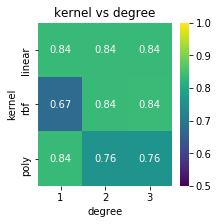

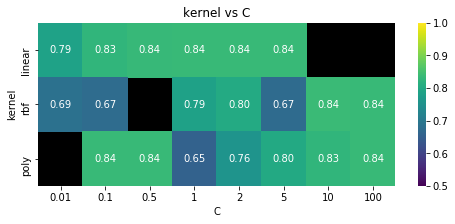

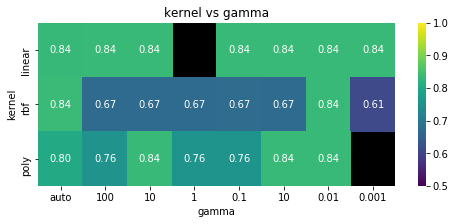

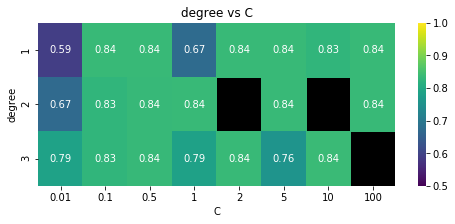

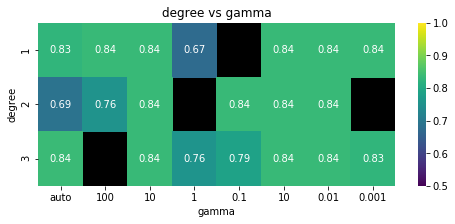

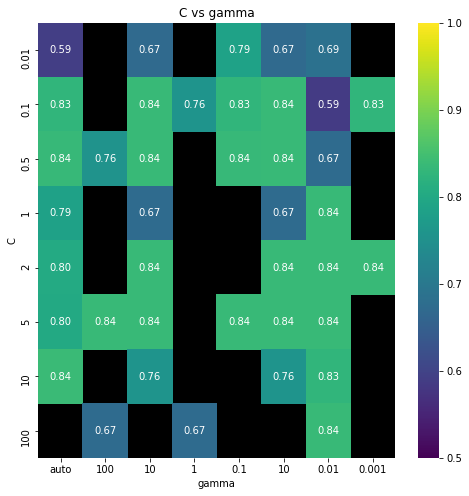

In [156]:
import itertools
import seaborn as sns

listables = []
for key, value in clf.param_distributions.items():
    if isinstance(value, list):
        listables.append(key)

for a, b in itertools.combinations(listables, 2):
#     print(a,b)
    params_a = clf.param_distributions[a]
    params_b = clf.param_distributions[b]
    
    results = []
    for val_a, val_b in itertools.product(params_a, params_b):
        crit_a = clf.cv_results_[f'param_{a}'] == val_a
        crit_b = clf.cv_results_[f'param_{b}'] == val_b
        try:
            best = np.max(clf.cv_results_['mean_test_score'][crit_a & crit_b])
        except ValueError:
            best = np.nan 
        results.append(best)
#         print('\t', val_a, val_b, best)
    results = np.array(results).reshape((len(params_a), len(params_b)))

    plt.figure(figsize=(len(params_b), len(params_a)))
    ax = sns.heatmap(results, xticklabels=params_b, yticklabels=params_a, annot=True, fmt=".2f", vmin=0.5, vmax=1.0, cmap='viridis')
    ax.set_facecolor("black")
    ax.set_title(f"{a} vs {b}")
    ax.set(xlabel=b, ylabel=a)

## Fit the best estimator ##

In [171]:
print(clf.best_params_)
print(clf.best_score_)
best_estimator = clf.estimator.set_params(probability=True, **clf.best_params_)
best_estimator.fit(X, y, _timeout=100)
print()

print('non-balanced:')
evaluate_model(best_estimator, test_data)
print()

print('balanced:')
idx, y_pred, y_true = evaluate_model(best_estimator, test_data, balanced=True)

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10}
0.8392416525212695

non-balanced:
[[8655  458]
 [ 279  608]]
accuracy: 0.9263
precision: 0.7695637300176277
recall: 0.8175993609486107
fscore: 0.7908970180297556
support: Counter({0: 9113, 1: 887})

balanced:
[[4795  276]
 [1450 3479]]
accuracy: 0.8274
precision: 0.8471561270321184
recall: 0.8256977736990887
fscore: 0.8243581358369809
support: Counter({0: 5071, 1: 4929})


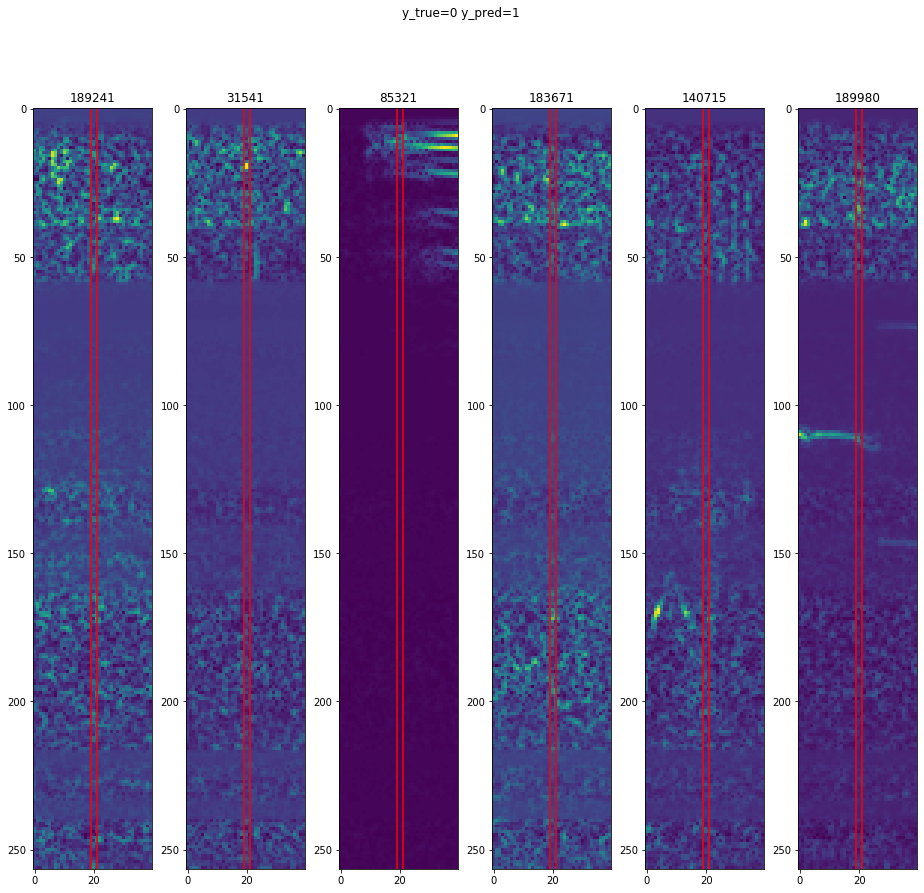

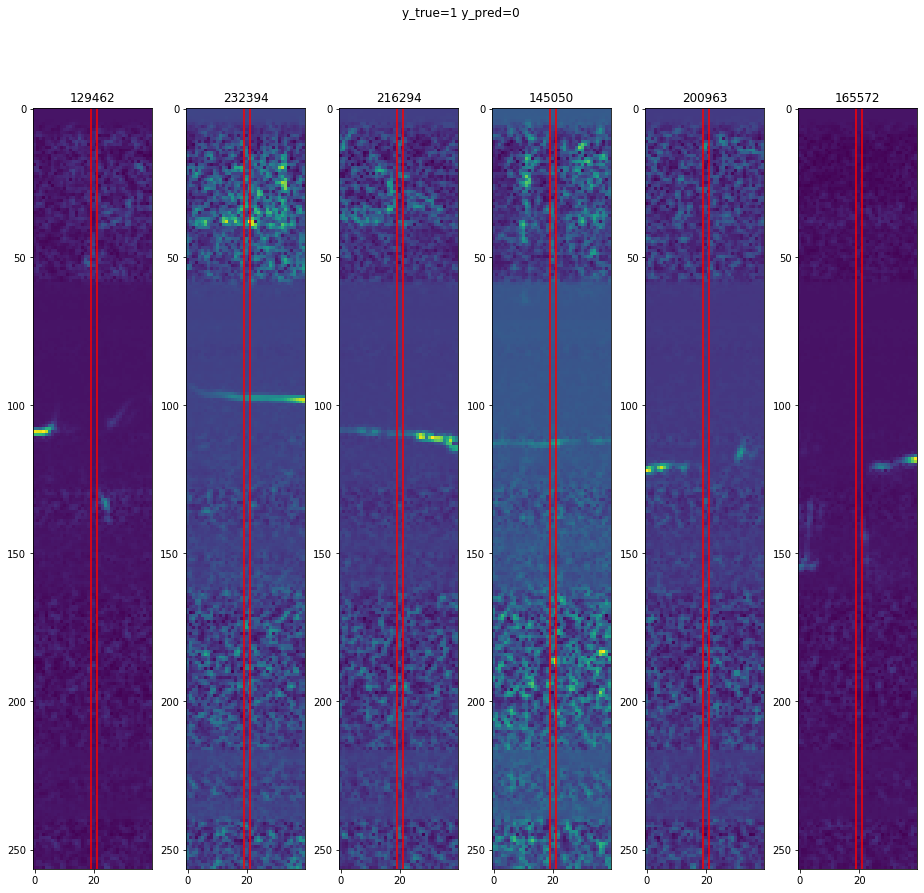

In [150]:
N = 6

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=0 y_pred=1')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==1) & (y_true == 0)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=1 y_pred=0')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==0) & (y_true == 1)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')


# Generate Selection file #

In [152]:
from sklearn.metrics import classification_report

%time y_pred = best_estimator.predict(test_data.X)

print(classification_report(test_data.y_binary, y_pred))

print(Counter(y_pred))
print(Counter(test_data.y_binary))

CPU times: user 3min 8s, sys: 2.11 s, total: 3min 10s
Wall time: 3min 10s
             precision    recall  f1-score   support

          0       0.97      0.95      0.96    213835
          1       0.58      0.71      0.64     20550

avg / total       0.94      0.93      0.93    234385

Counter({0: 209093, 1: 25292})
Counter({0: 213835, 1: 20550})


In [154]:
import pandas as pd

def predict_annotations(dataset, y_pred, *, smoothing=0, min_length=0):
    annotations = []
    
    for i, value in enumerate(y_pred):
        if value == 1:
            if len(annotations) and i - annotations[-1][1] - 1 <= smoothing:
                annotations[-1][1] = i
            else:
                annotations.append([i, i])

    annotations = [(a, b) for a, b in annotations if b - a + 1 >= min_length]
    
    return annotations


def create_selection_table(dataset, annotations):
    return pd.DataFrame.from_records([
        (i, 'Spectrogram 1', 1, dataset.frame_to_time(a), dataset.frame_to_time(b), dataset.meta['audio_name']) for i, (a, b) in enumerate(annotations, 1)
    ], columns=[
        'Selection',
        'View',
        'Channel',
        'Begin Time (s)',
        'End Time (s)',
        'Begin Path',
    ], index='Selection')
    
ann = predict_annotations(test_data, y_pred, smoothing=5, min_length=20)

df = create_annotations_table(test_data, ann)

df.to_csv(test_data.meta['audio_name'].replace('.wav', '.trimed.txt'), sep="\t")
df.head(20)

,View,Channel,Begin Time (s),End Time (s),Begin Path
Selection,,,,,
1,Spectrogram 1,1,1.496064,1.508864,ch1-2018-11-20_10-26-36_0000010.wav
2,Spectrogram 1,1,1.515008,1.525248,ch1-2018-11-20_10-26-36_0000010.wav
3,Spectrogram 1,1,1.618432,1.659904,ch1-2018-11-20_10-26-36_0000010.wav
4,Spectrogram 1,1,2.163200,2.200064,ch1-2018-11-20_10-26-36_0000010.wav
5,Spectrogram 1,1,2.337280,2.376192,ch1-2018-11-20_10-26-36_0000010.wav
6,Spectrogram 1,1,2.400768,2.412544,ch1-2018-11-20_10-26-36_0000010.wav
7,Spectrogram 1,1,2.901504,2.973184,ch1-2018-11-20_10-26-36_0000010.wav
8,Spectrogram 1,1,3.098112,3.119616,ch1-2018-11-20_10-26-36_0000010.wav
9,Spectrogram 1,1,3.130880,3.144192,ch1-2018-11-20_10-26-36_0000010.wav


# TODO: Check predictions with LIME #

- https://pbiecek.github.io/PM_VEE/LIME.html
- https://github.com/pbiecek/InterpretableMachineLearning2018S
- biblioteka: https://github.com/marcotcr/lime

In [162]:
# best_estimator.predict
import lime.lime_tabular

In [271]:
labels = librosa.fft_frequencies(sr=test_data.meta['sampling_rate'], n_fft=test_data.meta['n_fft'])

labels = [f"{x:.2f}Hz" for x in labels]
print(labels, len(labels))

explainer = lime.lime_tabular.LimeTabularExplainer(
    X,
    feature_names=labels,
#     class_names=iris.target_names,
    discretize_continuous=True
)

['0.00Hz', '488.28Hz', '976.56Hz', '1464.84Hz', '1953.12Hz', '2441.41Hz', '2929.69Hz', '3417.97Hz', '3906.25Hz', '4394.53Hz', '4882.81Hz', '5371.09Hz', '5859.38Hz', '6347.66Hz', '6835.94Hz', '7324.22Hz', '7812.50Hz', '8300.78Hz', '8789.06Hz', '9277.34Hz', '9765.62Hz', '10253.91Hz', '10742.19Hz', '11230.47Hz', '11718.75Hz', '12207.03Hz', '12695.31Hz', '13183.59Hz', '13671.88Hz', '14160.16Hz', '14648.44Hz', '15136.72Hz', '15625.00Hz', '16113.28Hz', '16601.56Hz', '17089.84Hz', '17578.12Hz', '18066.41Hz', '18554.69Hz', '19042.97Hz', '19531.25Hz', '20019.53Hz', '20507.81Hz', '20996.09Hz', '21484.38Hz', '21972.66Hz', '22460.94Hz', '22949.22Hz', '23437.50Hz', '23925.78Hz', '24414.06Hz', '24902.34Hz', '25390.62Hz', '25878.91Hz', '26367.19Hz', '26855.47Hz', '27343.75Hz', '27832.03Hz', '28320.31Hz', '28808.59Hz', '29296.88Hz', '29785.16Hz', '30273.44Hz', '30761.72Hz', '31250.00Hz', '31738.28Hz', '32226.56Hz', '32714.84Hz', '33203.12Hz', '33691.41Hz', '34179.69Hz', '34667.97Hz', '35156.25Hz', '35

[1]
> [[2.85828782e-09 9.99999997e-01]]


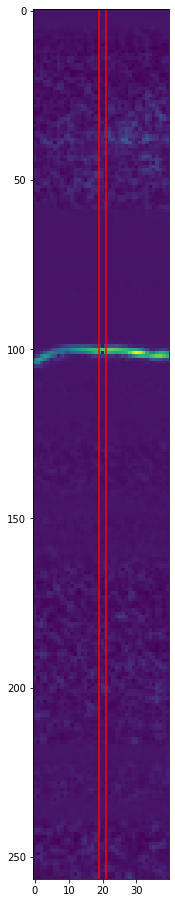

In [312]:
idx, record, y = test_data.sample(1, with_idx=True, random_state=13, balanced=True)
pos = idx[0]
print(y)
record[0,[99,101]] = 0
print('>', best_estimator.predict_proba(record))

fig = plt.figure(figsize=(8,16))
zzz = np.array(test_data.X[pos-20:pos+20].T)
zzz[:,20] = record
ax = plt.imshow(zzz)
# fig.set_title(f"{pos}")
plt.axvline(19,color='red')
plt.axvline(21,color='red')

In [285]:
exp = explainer.explain_instance(
    record[0],
    predict_fn=best_estimator.predict_proba,
    num_features=25
)

In [286]:
exp.show_in_notebook(show_table=True, show_all=False)

In [275]:
exp.as_list()

[('113769.53Hz > 0.13', -0.0008033340798465354),
 ('48828.12Hz > -0.02', 0.0006171759151898759),
 ('124023.44Hz > 0.25', -0.0006037289142211973),
 ('79589.84Hz > 0.20', -0.0004700488394508369),
 ('3417.97Hz > 0.13', -0.0004326928641925271),
 ('47851.56Hz > -0.04', 0.0004056371315116597),
 ('-0.23 < 110839.84Hz <= -0.05', 0.00039908000776631944),
 ('49316.41Hz > -0.02', 0.00038837807752862793),
 ('25878.91Hz > 0.38', -0.00038278046164027564),
 ('-0.05 < 36132.81Hz <= -0.02', -0.0003662009712425453),
 ('68847.66Hz <= -0.20', 0.0003614360371588072),
 ('25390.62Hz > 0.39', -0.00035655533851499576),
 ('43945.31Hz <= -0.09', 0.00034455169262641126),
 ('-0.04 < 79101.56Hz <= 0.17', 0.00033688155881716044),
 ('-0.14 < 69824.22Hz <= -0.05', 0.0003327149963525888),
 ('102050.78Hz <= -0.28', 0.0003162634364942885),
 ('23437.50Hz > 0.42', -0.000313825745367338),
 ('-0.28 < 112792.97Hz <= -0.05', 0.0002924051579501929),
 ('48339.84Hz > -0.03', 0.0002862732785119022),
 ('-0.42 < 86914.06Hz <= -0.07'

In [261]:
import lime.lime_image
explainer = lime.lime_image.LimeImageExplainer()


In [265]:
exp = explainer.explain_instance(
    record[0],
    classifier_fn=best_estimator.predict_proba,
#     num_features=258
)

ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (1, 257, 1)

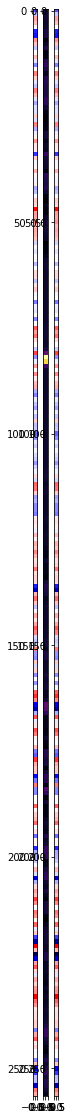

In [254]:
import re

lss = {}
for a, b in exp.as_list():
    a = re.search('\d+\.\d{2}Hz', a).group()
#     print(a, b)
    lss[a] = b
    
# assert lss == set(labels)

weights = np.array([lss[l] for l in labels])
# print(weights, weights.shape)
fig, axs= plt.subplots(1, 3, figsize=(4,20))
bbox = max(abs(np.min(weights)), abs(np.max(weights)))
# ax = sns.heatmap(weights.reshape(-1, 1), yticklabels=labels, cmap='seismic', vmin=-bbox, vmax=bbox)
axs[0].imshow(weights.reshape(-1, 1), cmap='seismic', vmin=-bbox, vmax=bbox)
axs[1].imshow(record.T, cmap='inferno')
axs[2].imshow(weights.reshape(-1, 1), cmap='seismic', vmin=-bbox, vmax=bbox)
fig.subplots_adjust(left=0,right=0.1)

# SHAP #


In [ ]:
import shap

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(best_estimator.predict_proba, X, link="logit")
shap_values = explainer.shap_values(record)#, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


# TODO: Random Forest Classifier #

In [17]:
# import sys
# import unittest.mock
# import sklearn
# from sklearn.model_selection import RandomizedSearchCV


# def _fit_and_score(estimator, *args, **kwargs):
#     print('Faking fit')
#     orig_fit_and_score(estimtor, *args, **kwargs)

# class RandomizedSearchCVWithTimeout(RandomizedSearchCV):
#     def __init__(self, estimator, param_distributions, n_iter=10, scoring=None,
#                  n_jobs=None, iid='deprecated', refit=True,
#                  cv=None, verbose=0, pre_dispatch='2*n_jobs',
#                  random_state=None, error_score=np.nan,
#                  return_train_score=False, timeout=None):
#         super().__init__(estimator=estimator, param_distributions=param_distributions, 
#                          n_iter=n_iter, scoring=scoring, n_jobs=n_jobs, iid=iid, refit=refit,
#                          cv=cv, verbose=verbose, pre_dispatch=pre_dispatch,
#                          random_state=random_state, error_score=error_score,
#                          return_train_score=return_train_score)
        
#         self._timeout = timeout
#     def fit(self, *args, **kwargs):
#         orig_fit_and_score = sklearn.model_selection._validation._fit_and_score
        
#         def timeouted_fit(estimator):
#             orig = estimator.fit
#             return orig
        
#         def _fit_and_score(estimator, *args, **kwargs):
#             print('Faking fit')
#             orig_fit_and_score(estimtor, *args, **kwargs)
# #             with unittest.mock.patch(estimator.fit, timeouted_fit(estimator)):
# #                 orig_fit_and_score(estimator, *args, **kwargs)
        
        
#         with unittest.mock.patch('sklearn.model_selection._validation._fit_and_score', _fit_and_score):
#             super().fit(*args, **kwargs)
            
            
# # #     @property
# # #     def verbose(self):
# # #         frame = sys._getframe(1)
# # #         print(dir(frame))
# # #         if str(frame.f_code.co_filename).endswith('sklearn/model_selection/_search.py'):
# # #             print('-'*20, frame.f_lineno)
# # #             print(frame.f_code.co_filename)
# # #             print('>>', frame.f_locals.keys())
# # # #         print(sys._getframe(1).f_code.co_filename)
# # # #         print('*'*100)
# # #         return self._verbose
# # #     @verbose.setter
# # #     def verbose(self, value):
# # #         self._verbose = value
    
# # #     def _run_search(self, evaluate_candidates):
# # #         print('run_search')
# # #         raise RuntimeError()
        
# # print(RandomizedSearchCVWithTimeout.mro())

In [1]:
# from sklearn.ensemble import RandomForestClassifier

# parameters = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [20, 40, 100],
# }

# rf = RandomForestClassifier(random_state=0)

# clf = GridSearchCV(rf, parameters, cv=5, verbose=10)

# clf.fit(X, y_binary)

# # clf.cv_results_
# print(clf.best_params_, clf.best_score_)

In [3]:
# print(clf.best_params_, clf.best_score_)

In [2]:
# idx, y_pred, y_true = evaluate_model(rf, train_data)

## Jak oceniać modele? jaka miara? ##
## Jak normalizować dane? potrzebne dla SVMa ##